Análise de Viabilidade com Redes Neurais - Programa Criança Feliz
Autor: Paulo Renato Restaino
Data Science e Analytics - USP/Esalq


## 1. Importação de Bibliotecas e Configuração Inicial



### Bibliotecas para preparação dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

### Bibliotecas para modelagem


In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Deep Learning


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

### Visualizações interativas


In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Configurações

In [5]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Definir seed para reprodutibilidade

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.19.0
GPU disponível: False


In [7]:
def load_pcf_data():
    """Carrega todos os arquivos CSV do Programa Criança Feliz"""
    
    # Dicionário para armazenar os dataframes
    dfs = {}
    
    # Lista de arquivos e suas colunas esperadas
    files_info = {
        'crianca2018.csv': {
            'year': 2018,
            'cols': ['codigo_ibge', 'anomes_s', 'visitas_realizadas_criancas_pcf_i', 
                    'visitas_realizadas_gestantes_pcf_i', 'total_visitas_realizadas_pcf_i']
        },
        'crianca2019.csv': {
            'year': 2019,
            'cols': ['codigo_ibge', 'anomes_s', 'visitas_realizadas_criancas_pcf_i', 
                    'visitas_realizadas_gestantes_pcf_i', 'total_visitas_realizadas_pcf_i']
        },
        'crianca2020.csv': {
            'year': 2020,
            'cols': ['codigo_ibge', 'anomes_s', 'visitas_realizadas_criancas_pcf_i', 
                    'visitas_realizadas_gestantes_pcf_i', 'total_visitas_realizadas_pcf_i']
        },
        'crianca2021.csv': {
            'year': 2021,
            'cols': ['codigo_ibge', 'anomes_s', 'qtd_criancas_visitadas_pcf_i', 
                    'qtd_gestantes_visitadas_pcf_i', 'total_pessoas_visitadas_pcf_i']
        },
        'crianca2022.csv': {
            'year': 2022,
            'cols': ['codigo_ibge', 'anomes_s', 'qtd_criancas_visitadas_pcf_i', 
                    'qtd_gestantes_visitadas_pcf_i', 'total_pessoas_visitadas_pcf_i']
        }
    }
    
    for filename, info in files_info.items():
        try:
            df = pd.read_csv(filename)
            
            # Padronizar nomes de colunas
            if 'qtd_criancas_visitadas_pcf_i' in df.columns:
                df = df.rename(columns={
                    'qtd_criancas_visitadas_pcf_i': 'visitas_criancas',
                    'qtd_gestantes_visitadas_pcf_i': 'visitas_gestantes',
                    'total_pessoas_visitadas_pcf_i': 'total_visitas'
                })
            else:
                df = df.rename(columns={
                    'visitas_realizadas_criancas_pcf_i': 'visitas_criancas',
                    'visitas_realizadas_gestantes_pcf_i': 'visitas_gestantes',
                    'total_visitas_realizadas_pcf_i': 'total_visitas'
                })
            
            dfs[info['year']] = df
            print(f"✓ Carregado {filename}: {len(df)} registros")
            
        except Exception as e:
            print(f"✗ Erro ao carregar {filename}: {str(e)}")
        
    df_combined = pd.concat(dfs.values(), ignore_index=True)

    df_combined['ano'] = df_combined['anomes_s'].astype(str).str[:4].astype(int)
    df_combined['mes'] = df_combined['anomes_s'].astype(str).str[4:6].astype(int)
    df_combined['data'] = pd.to_datetime(df_combined['anomes_s'].astype(str), format='%Y%m')
    
    return df_combined


In [8]:
df_pcf = load_pcf_data()


✓ Carregado crianca2018.csv: 25292 registros
✓ Carregado crianca2019.csv: 29311 registros
✓ Carregado crianca2020.csv: 30250 registros
✓ Carregado crianca2021.csv: 31725 registros
✓ Carregado crianca2022.csv: 16581 registros


In [9]:
df_pcf

,codigo_ibge,anomes_s,visitas_criancas,visitas_gestantes,total_visitas,ano,mes,data
0,110005,201801,204,33.0,237,2018,1,2018-01-01
1,110007,201801,1,0.0,1,2018,1,2018-01-01
2,110009,201801,52,1.0,53,2018,1,2018-01-01
3,110025,201801,173,6.0,179,2018,1,2018-01-01
4,110070,201801,113,7.0,120,2018,1,2018-01-01
...,...,...,...,...,...,...,...,...
133154,522185,202201,154,8.0,162,2022,1,2022-01-01
133155,522200,202201,87,15.0,102,2022,1,2022-01-01
133156,522205,202201,94,11.0,105,2022,1,2022-01-01
133157,522220,202201,36,NaN,36,2022,1,2022-01-01


In [10]:
df_municipios = pd.read_csv('municipio_elegivel.csv')
print(f"\n✓ Carregado municipio_elegivel.csv: {len(df_municipios)} registros")


✓ Carregado municipio_elegivel.csv: 52920 registros


In [11]:
df_municipios

,codigo_ibge,anomes_s,municipios_elegiveis_pcf_i,municipios_adesao_pcf_i
0,110001,201809,1,NaN
1,110002,201809,1,1.0
2,110004,201809,1,1.0
3,110005,201809,1,1.0
4,110007,201809,1,1.0
...,...,...,...,...
52915,522185,201910,1,1.0
52916,522200,201910,1,1.0
52917,522205,201910,1,1.0
52918,522220,201910,1,1.0


In [12]:
print("=== INFORMAÇÕES DO DATASET PCF ===")
print(f"Período: {df_pcf['data'].min()} a {df_pcf['data'].max()}")
print(f"Total de registros: {len(df_pcf):,}")
print(f"Municípios únicos: {df_pcf['codigo_ibge'].nunique():,}")
print(f"Anos disponíveis: {sorted(df_pcf['ano'].unique())}")

print("\n=== ESTATÍSTICAS DESCRITIVAS ===")
print(df_pcf[['visitas_criancas', 'visitas_gestantes', 'total_visitas']].describe())

=== INFORMAÇÕES DO DATASET PCF ===
Período: 2018-01-01 00:00:00 a 2022-06-01 00:00:00
Total de registros: 133,159
Municípios únicos: 2,981
Anos disponíveis: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]

=== ESTATÍSTICAS DESCRITIVAS ===
       visitas_criancas  visitas_gestantes  total_visitas
count     133159.000000      128945.000000  133159.000000
mean         336.783049          15.293862     351.592915
std          414.359732          22.154742     426.376899
min            0.000000           0.000000       1.000000
25%          119.000000           4.000000     129.000000
50%          252.000000          10.000000     265.000000
75%          398.000000          19.000000     412.000000
max        14179.000000         828.000000   14599.000000


In [13]:
df_temporal = df_pcf.groupby('data').agg({
    'visitas_criancas': 'sum',
    'visitas_gestantes': 'sum',
    'total_visitas': 'sum'
}).reset_index()

# Criar visualização interativa
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Evolução Mensal das Visitas', 'Taxa de Crescimento Mensal'),
    vertical_spacing=0.1,
    row_heights=[0.7, 0.3]
)

# Gráfico de linhas
fig.add_trace(
    go.Scatter(x=df_temporal['data'], y=df_temporal['visitas_criancas'],
               name='Visitas Crianças', line=dict(color='blue', width=2)),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df_temporal['data'], y=df_temporal['visitas_gestantes'],
               name='Visitas Gestantes', line=dict(color='red', width=2)),
    row=1, col=1
)

# Taxa de crescimento
df_temporal['crescimento_total'] = df_temporal['total_visitas'].pct_change() * 100
fig.add_trace(
    go.Bar(x=df_temporal['data'], y=df_temporal['crescimento_total'],
           name='Taxa de Crescimento (%)', marker_color='green'),
    row=2, col=1
)

fig.update_layout(height=800, title_text="Análise Temporal do Programa Criança Feliz")
fig.update_xaxes(title_text="Data", row=2, col=1)
fig.update_yaxes(title_text="Número de Visitas", row=1, col=1)
fig.update_yaxes(title_text="Crescimento (%)", row=2, col=1)
fig.show()

In [14]:
df_municipios_top = df_pcf.groupby('codigo_ibge')['total_visitas'].sum().sort_values(ascending=False).head(20)

# Análise por região (primeiro dígito do código IBGE)
df_pcf['regiao'] = df_pcf['codigo_ibge'].astype(str).str[0].map({
    '1': 'Norte',
    '2': 'Nordeste',
    '3': 'Sudeste',
    '4': 'Sul',
    '5': 'Centro-Oeste'
})

df_regional = df_pcf.groupby(['ano', 'regiao'])['total_visitas'].sum().reset_index()

# Visualização por região
fig = px.bar(df_regional, x='ano', y='total_visitas', color='regiao',
             title='Distribuição Regional das Visitas por Ano',
             labels={'total_visitas': 'Total de Visitas', 'ano': 'Ano'})
fig.show()


In [15]:
df_pcf['mes_nome'] = pd.to_datetime(df_pcf['mes'], format='%m').dt.month_name()
df_sazonal = df_pcf.groupby(['mes', 'mes_nome'])['total_visitas'].mean().reset_index()
df_sazonal = df_sazonal.sort_values('mes')

fig = px.bar(df_sazonal, x='mes_nome', y='total_visitas',
             title='Padrão de Sazonalidade Mensal (Média de Visitas)',
             labels={'total_visitas': 'Média de Visitas', 'mes_nome': 'Mês'})
fig.show()

In [16]:
df_analise = pd.merge(
    df_pcf,
    df_municipios[['codigo_ibge', 'anomes_s', 'municipios_adesao_pcf_i']],
    on=['codigo_ibge', 'anomes_s'],
    how='left'
)

# Análise de adesão
df_adesao = df_analise.groupby(['data', 'municipios_adesao_pcf_i'])['total_visitas'].sum().reset_index()
df_adesao['status_adesao'] = df_adesao['municipios_adesao_pcf_i'].map({
    1.0: 'Aderente',
    0.0: 'Não Aderente'
}).fillna('Sem informação')

fig = px.line(df_adesao[df_adesao['status_adesao'] != 'Sem informação'], 
              x='data', y='total_visitas', color='status_adesao',
              title='Comparação: Municípios Aderentes vs Não Aderentes',
              labels={'total_visitas': 'Total de Visitas', 'data': 'Data'})
fig.show()

In [17]:
df_analise

,codigo_ibge,anomes_s,visitas_criancas,visitas_gestantes,total_visitas,ano,mes,data,regiao,mes_nome,municipios_adesao_pcf_i
0,110005,201801,204,33.0,237,2018,1,2018-01-01,Norte,January,NaN
1,110007,201801,1,0.0,1,2018,1,2018-01-01,Norte,January,NaN
2,110009,201801,52,1.0,53,2018,1,2018-01-01,Norte,January,NaN
3,110025,201801,173,6.0,179,2018,1,2018-01-01,Norte,January,NaN
4,110070,201801,113,7.0,120,2018,1,2018-01-01,Norte,January,NaN
...,...,...,...,...,...,...,...,...,...,...,...
133154,522185,202201,154,8.0,162,2022,1,2022-01-01,Centro-Oeste,January,NaN
133155,522200,202201,87,15.0,102,2022,1,2022-01-01,Centro-Oeste,January,NaN
133156,522205,202201,94,11.0,105,2022,1,2022-01-01,Centro-Oeste,January,NaN
133157,522220,202201,36,NaN,36,2022,1,2022-01-01,Centro-Oeste,January,NaN


In [18]:
def create_temporal_features(df):
    """Cria features temporais para melhorar a performance dos modelos"""
    df = df.copy()
    
    # Features básicas
    df['trimestre'] = df['mes'].apply(lambda x: (x-1)//3 + 1)
    df['semestre'] = df['mes'].apply(lambda x: 1 if x <= 6 else 2)
    df['dia_ano'] = df['data'].dt.dayofyear
    df['semana_ano'] = df['data'].dt.isocalendar().week
    
    # Features cíclicas (seno e cosseno para capturar padrões circulares)
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    df['trimestre_sin'] = np.sin(2 * np.pi * df['trimestre'] / 4)
    df['trimestre_cos'] = np.cos(2 * np.pi * df['trimestre'] / 4)
    
    return df

# Função para criar lags (valores passados)
def create_lag_features(df, columns, lags):
    """Cria features de lag para as colunas especificadas"""
    df = df.copy()
    
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('codigo_ibge')[col].shift(lag)
    
    return df

# Função para criar features de janela móvel
def create_rolling_features(df, columns, windows):
    """Cria features de média móvel e desvio padrão"""
    df = df.copy()
    
    for col in columns:
        for window in windows:
            df[f'{col}_ma_{window}'] = df.groupby('codigo_ibge')[col].transform(
                lambda x: x.rolling(window, min_periods=1).mean()
            )
            df[f'{col}_std_{window}'] = df.groupby('codigo_ibge')[col].transform(
                lambda x: x.rolling(window, min_periods=1).std()
            )
    
    return df

In [19]:
print("Criando features temporais...")
df_model = create_temporal_features(df_pcf)

print("Criando features de lag...")
lag_columns = ['visitas_criancas', 'visitas_gestantes', 'total_visitas']
df_model = create_lag_features(df_model, lag_columns, [1, 2, 3, 6, 12])

print("Criando features de janela móvel...")
df_model = create_rolling_features(df_model, lag_columns, [3, 6, 12])

# Adicionar informações de adesão
df_model = pd.merge(
    df_model,
    df_municipios[['codigo_ibge', 'anomes_s', 'municipios_elegiveis_pcf_i', 'municipios_adesao_pcf_i']],
    on=['codigo_ibge', 'anomes_s'],
    how='left'
)

# Preencher valores faltantes
df_model['municipios_adesao_pcf_i'] = df_model['municipios_adesao_pcf_i'].fillna(0)
df_model['municipios_elegiveis_pcf_i'] = df_model['municipios_elegiveis_pcf_i'].fillna(0)

print(f"\nDataset após engenharia de features: {df_model.shape}")

Criando features temporais...
Criando features de lag...
Criando features de janela móvel...

Dataset após engenharia de features: (133159, 53)


In [20]:
codigo_exemplo = 3550308
df_exemplo = df_model[df_model['codigo_ibge'] == codigo_exemplo].sort_values('data')

# Se São Paulo não tiver dados suficientes, pegar o município com mais registros
if len(df_exemplo) < 24:
    municipio_mais_dados = df_model.groupby('codigo_ibge').size().idxmax()
    df_exemplo = df_model[df_model['codigo_ibge'] == municipio_mais_dados].sort_values('data')
    print(f"Usando município {municipio_mais_dados} para demonstração")

# Remover linhas com NaN após criar lags
df_exemplo = df_exemplo.dropna()

# Definir features e target
feature_columns = [col for col in df_exemplo.columns if col not in [
    'codigo_ibge', 'anomes_s', 'data', 'ano', 'mes_nome', 'regiao',
    'visitas_criancas', 'visitas_gestantes', 'total_visitas'
]]

X = df_exemplo[feature_columns].values
y = df_exemplo['total_visitas'].values

print(f"Shape dos dados: X={X.shape}, y={y.shape}")


Usando município 110005 para demonstração
Shape dos dados: X=(42, 44), y=(42,)


In [21]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Divisão temporal (80% treino, 20% teste)
split_idx = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

Dados de treino: (33, 44)
Dados de teste: (9, 44)


In [22]:
def create_sequences(X, y, seq_length):
    """Cria sequências para modelos de séries temporais"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)

# Criar sequências
SEQ_LENGTH = 6  # Usar últimos 6 meses para prever o próximo
X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LENGTH)

print(f"Shape das sequências de treino: {X_train_seq.shape}")
print(f"Shape das sequências de teste: {X_test_seq.shape}")

Shape das sequências de treino: (27, 6, 44)
Shape das sequências de teste: (3, 6, 44)


In [23]:
def build_lstm_model(input_shape):
    """Constrói modelo LSTM para previsão de séries temporais"""
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Criar e treinar modelo LSTM
lstm_model = build_lstm_model((SEQ_LENGTH, X_train_seq.shape[2]))
print(lstm_model.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Treinar
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 128)         │        88,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,945 (589.63 KB)

 Trainable params: 150,945 (589.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - loss: 0.2958 - mae: 0.4771 - val_loss: 0.0023 - val_mae: 0.0455 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1863 - mae: 0.3716 - val_loss: 0.0025 - val_mae: 0.0441 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1034 - mae: 0.2834 - val_loss: 0.0189 - val_mae: 0.1322 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0597 - mae: 0.2234 - val_loss: 0.0559 - val_mae: 0.2312 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0654 - mae: 0.1899 - val_loss: 0.0965 - val_mae: 0.3049 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0975 - mae: 0.2221 - val_loss: 0.1001 - val_mae: 0.3110 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0690 - mae: 0.2024 - val_loss: 0.0911 - val_mae: 0.2967 - learning_rate: 5.0000e-04
Epoch 8/

In [ ]:
def build_gru_model(input_shape):
    """Constrói modelo GRU para previsão de séries temporais"""
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=True),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Criar e treinar modelo GRU
gru_model = build_gru_model((SEQ_LENGTH, X_train_seq.shape[2]))

history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

In [27]:
def build_gru_model(input_shape):
    """Constrói modelo GRU para previsão de séries temporais"""
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=True),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Criar e treinar modelo GRU
gru_model = build_gru_model((SEQ_LENGTH, X_train_seq.shape[2]))

history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3087 - mae: 0.4913 - val_loss: 0.0016 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1794 - mae: 0.3706 - val_loss: 0.0155 - val_mae: 0.1201 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.1384 - mae: 0.3172 - val_loss: 0.0425 - val_mae: 0.2030 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0661 - mae: 0.2235 - val_loss: 0.0868 - val_mae: 0.2925 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0805 - mae: 0.2210 - val_loss: 0.1154 - val_mae: 0.3378 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0685 - mae: 0.1940 - val_loss: 0.1123 - val_mae: 0.3334 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0916 - mae: 0.2340 - val_loss: 0.1040 - val_mae: 0.3204 - learning_rate: 5.0000e-04
Epoch 8/100


In [28]:
def build_cnn_lstm_model(input_shape):
    """Constrói modelo híbrido CNN-LSTM"""
    model = Sequential([
        # Camadas convolucionais para extração de features
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Camadas LSTM para capturar dependências temporais
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        
        # Camadas densas finais
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Criar e treinar modelo híbrido
cnn_lstm_model = build_cnn_lstm_model((SEQ_LENGTH, X_train_seq.shape[2]))

history_cnn_lstm = cnn_lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3642 - mae: 0.5394 - val_loss: 0.0101 - val_mae: 0.0949 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3134 - mae: 0.4886 - val_loss: 0.0054 - val_mae: 0.0660 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2865 - mae: 0.4607 - val_loss: 0.0022 - val_mae: 0.0425 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2298 - mae: 0.4102 - val_loss: 0.0011 - val_mae: 0.0303 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.2023 - mae: 0.3953 - val_loss: 0.0025 - val_mae: 0.0391 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1532 - mae: 0.3424 - val_loss: 0.0071 - val_mae: 0.0741 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1278 - mae: 0.3047 - val_loss: 0.0159 - val_mae: 0.1179 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━

In [29]:
def evaluate_model(model, X_test, y_test, scaler_y, model_name):
    """Avalia o desempenho do modelo"""
    # Fazer previsões
    y_pred_scaled = model.predict(X_test)
    
    # Reverter normalização
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    
    # Calcular métricas
    mse = mean_squared_error(y_test_original, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100
    
    print(f"\n=== Métricas do Modelo {model_name} ===")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return y_pred, {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

# Avaliar todos os modelos
results = []

y_pred_lstm, metrics_lstm = evaluate_model(lstm_model, X_test_seq, y_test_seq, scaler_y, "LSTM")
results.append(metrics_lstm)

y_pred_gru, metrics_gru = evaluate_model(gru_model, X_test_seq, y_test_seq, scaler_y, "GRU")
results.append(metrics_gru)

y_pred_cnn_lstm, metrics_cnn_lstm = evaluate_model(cnn_lstm_model, X_test_seq, y_test_seq, scaler_y, "CNN-LSTM")
results.append(metrics_cnn_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step

=== Métricas do Modelo LSTM ===
RMSE: 32.95
MAE: 32.61
R²: -179.9207
MAPE: 39.16%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step

=== Métricas do Modelo GRU ===
RMSE: 7.85
MAE: 6.47
R²: -9.2620
MAPE: 7.82%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step

=== Métricas do Modelo CNN-LSTM ===
RMSE: 20.37
MAE: 19.01
R²: -68.1466
MAPE: 22.66%


In [30]:
y_test_original = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
dates_test = df_exemplo['data'].iloc[-len(y_test_seq):].values

# Criar gráfico comparativo
fig = go.Figure()

# Valores reais
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_test_original,
    mode='lines',
    name='Valores Reais',
    line=dict(color='black', width=2)
))

# Previsões LSTM
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_pred_lstm.flatten(),
    mode='lines',
    name='LSTM',
    line=dict(color='blue', width=2, dash='dash')
))

# Previsões GRU
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_pred_gru.flatten(),
    mode='lines',
    name='GRU',
    line=dict(color='red', width=2, dash='dash')
))

# Previsões CNN-LSTM
fig.add_trace(go.Scatter(
    x=dates_test,
    y=y_pred_cnn_lstm.flatten(),
    mode='lines',
    name='CNN-LSTM',
    line=dict(color='green', width=2, dash='dash')
))

fig.update_layout(
    title='Comparação das Previsões dos Modelos',
    xaxis_title='Data',
    yaxis_title='Total de Visitas',
    height=600
)

fig.show()


=== TABELA COMPARATIVA DE DESEMPENHO ===
   model      rmse       mae          r2      mape
     GRU  7.846796  6.474452   -9.262034  7.824337
CNN-LSTM 20.368598 19.011139  -68.146633 22.664728
    LSTM 32.947296 32.611416 -179.920715 39.158344


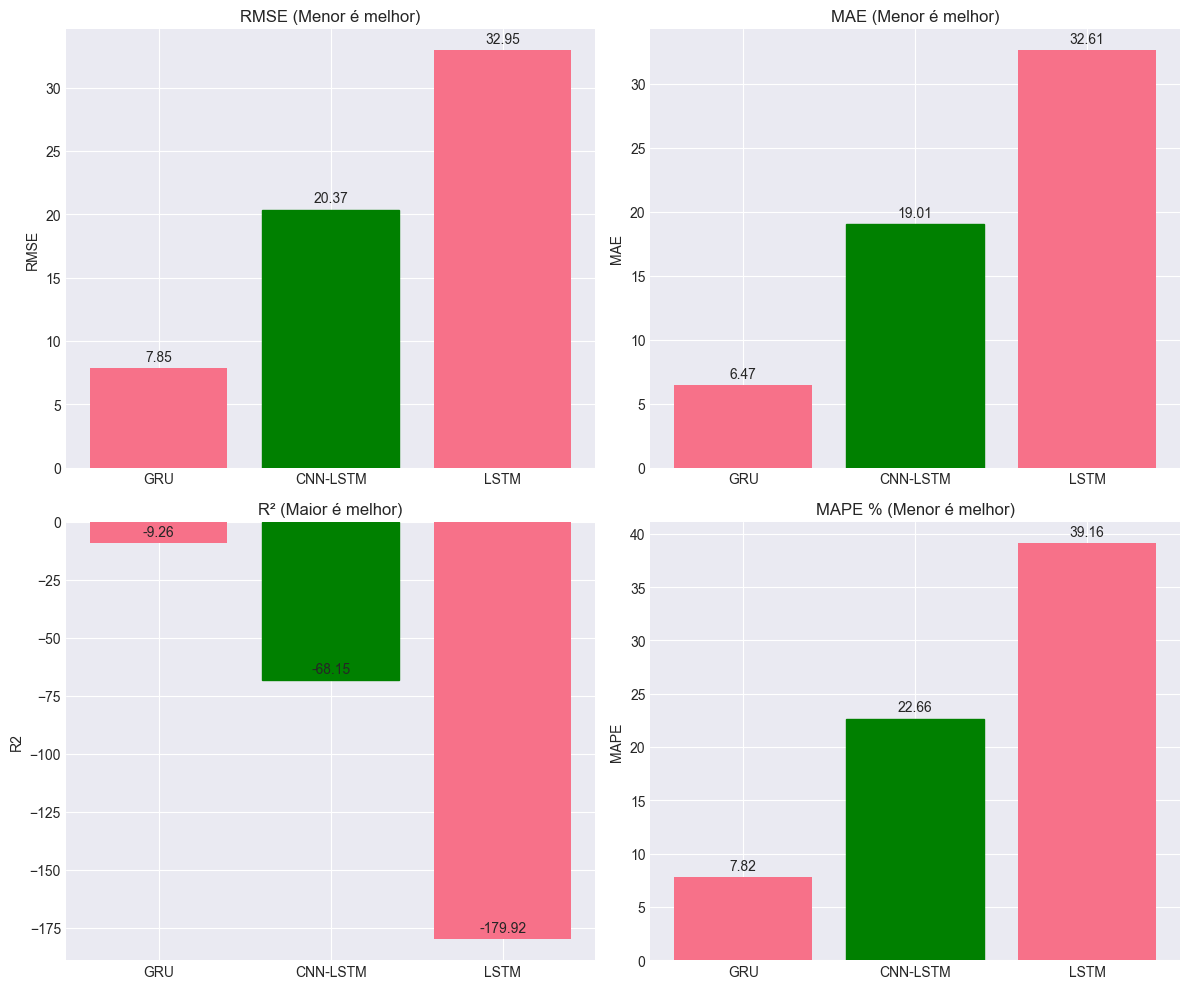

In [31]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('rmse')

# Visualizar tabela
print("\n=== TABELA COMPARATIVA DE DESEMPENHO ===")
print(df_results.to_string(index=False))

# Criar gráfico de barras para métricas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

metrics = ['rmse', 'mae', 'r2', 'mape']
titles = ['RMSE (Menor é melhor)', 'MAE (Menor é melhor)', 'R² (Maior é melhor)', 'MAPE % (Menor é melhor)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx//2, idx%2]
    bars = ax.bar(df_results['model'], df_results[metric])
    
    # Colorir a melhor barra
    if metric == 'r2':
        best_idx = df_results[metric].idxmax()
        bars[best_idx].set_color('green')
    else:
        best_idx = df_results[metric].idxmin()
        bars[best_idx].set_color('green')
    
    ax.set_title(title)
    ax.set_ylabel(metric.upper())
    
    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

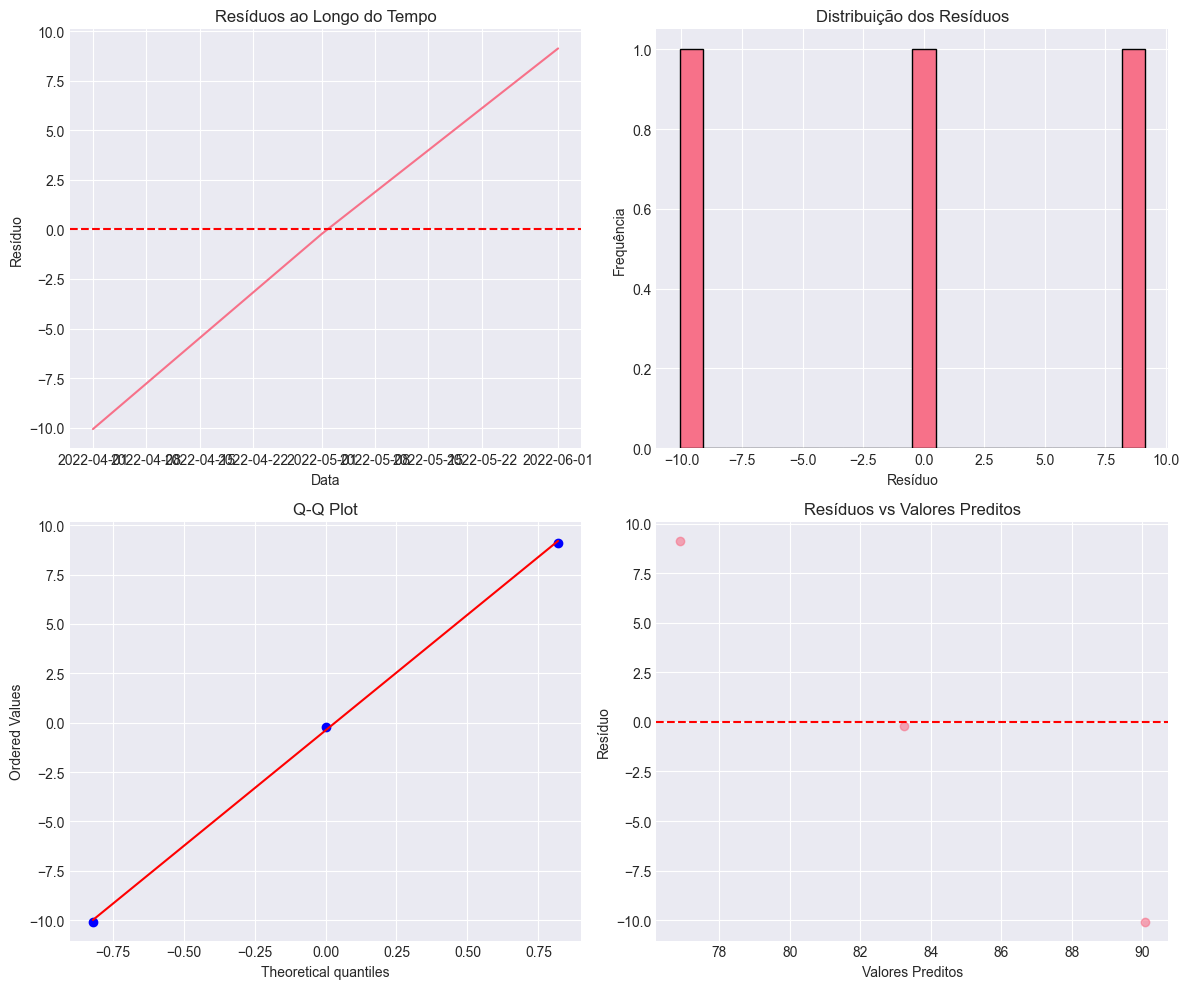

In [32]:
best_model_name = df_results.iloc[0]['model']
if best_model_name == 'LSTM':
    y_pred_best = y_pred_lstm
elif best_model_name == 'GRU':
    y_pred_best = y_pred_gru
else:
    y_pred_best = y_pred_cnn_lstm

residuals = y_test_original - y_pred_best.flatten()

# Visualizar resíduos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico de resíduos ao longo do tempo
axes[0, 0].plot(dates_test, residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Resíduos ao Longo do Tempo')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduo')

# Histograma dos resíduos
axes[0, 1].hist(residuals, bins=20, edgecolor='black')
axes[0, 1].set_title('Distribuição dos Resíduos')
axes[0, 1].set_xlabel('Resíduo')
axes[0, 1].set_ylabel('Frequência')

# Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# Resíduos vs Valores Preditos
axes[1, 1].scatter(y_pred_best.flatten(), residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_title('Resíduos vs Valores Preditos')
axes[1, 1].set_xlabel('Valores Preditos')
axes[1, 1].set_ylabel('Resíduo')

plt.tight_layout()
plt.show()


In [33]:
def predict_future(model, last_sequence, n_months, scaler_X, scaler_y):
    """Faz previsões para n_months meses futuros"""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_months):
        # Fazer previsão
        pred_scaled = model.predict(current_sequence.reshape(1, SEQ_LENGTH, -1), verbose=0)
        pred = scaler_y.inverse_transform(pred_scaled)[0, 0]
        predictions.append(pred)
        
        # Atualizar sequência (simplificado - em produção, atualizaria todas as features)
        # Aqui estamos apenas rolando a janela
        current_sequence = np.roll(current_sequence, -1, axis=0)
        # A última linha seria atualizada com as novas features do período previsto
        
    return predictions

# Fazer previsões para os próximos 6 meses
last_sequence = X_test_seq[-1]
future_predictions = predict_future(lstm_model, last_sequence, 6, scaler_X, scaler_y)

# Criar datas futuras
last_date = df_exemplo['data'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

# Visualizar previsões futuras
fig = go.Figure()

# Dados históricos
fig.add_trace(go.Scatter(
    x=df_exemplo['data'].iloc[-24:],
    y=df_exemplo['total_visitas'].iloc[-24:],
    mode='lines',
    name='Dados Históricos',
    line=dict(color='blue', width=2)
))

# Previsões futuras
fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_predictions,
    mode='lines+markers',
    name='Previsões Futuras',
    line=dict(color='red', width=2, dash='dash')
))

fig.update_layout(
    title='Previsões para os Próximos 6 Meses',
    xaxis_title='Data',
    yaxis_title='Total de Visitas',
    height=500
)

fig.show()